<a href="https://colab.research.google.com/github/suaaati/Handwritten_Digit_Recognition-/blob/main/UOWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter distance (meters): 200
Enter transmit power (Watts): 2

SNR vs BER for Clear Ocean:
 SNR (dB)  Monte Carlo BER
 0.000000     1.784400e-01
 2.142857     1.236900e-01
 4.285714     7.661000e-02
 6.428571     4.056000e-02
 8.571429     1.718000e-02
10.714286     5.390000e-03
12.857143     1.310000e-03
15.000000     2.300000e-04
17.142857     4.000000e-05
19.285714     1.000000e-45
21.428571     1.000000e-45
23.571429     1.000000e-45
25.714286     1.000000e-45
27.857143     1.000000e-45
30.000000     1.000000e-45

SNR vs BER for Coastal:
 SNR (dB)  Monte Carlo BER
 0.000000     1.802400e-01
 2.142857     1.250800e-01
 4.285714     7.618000e-02
 6.428571     4.012000e-02
 8.571429     1.700000e-02
10.714286     5.550000e-03
12.857143     1.460000e-03
15.000000     2.400000e-04
17.142857     3.000000e-05
19.285714     1.000000e-45
21.428571     1.000000e-45
23.571429     1.000000e-45
25.714286     1.000000e-45
27.857143     1.000000e-45
30.000000     1.000000e-45


/tmp/ipython-input-1887534622.py:72: RuntimeWarning: invalid value encountered in divide
  snr_theoretical = signal_power / (signal_power / snr_linear_values)



SNR vs BER for Turbid Harbor:
 SNR (dB)  Monte Carlo BER
 0.000000     1.781600e-01
 2.142857     1.243700e-01
 4.285714     7.768000e-02
 6.428571     3.976000e-02
 8.571429     1.728000e-02
10.714286     5.770000e-03
12.857143     1.310000e-03
15.000000     2.200000e-04
17.142857     2.000000e-05
19.285714     1.000000e-05
21.428571     1.000000e-45
23.571429     1.000000e-45
25.714286     1.000000e-45
27.857143     1.000000e-45
30.000000     1.000000e-45


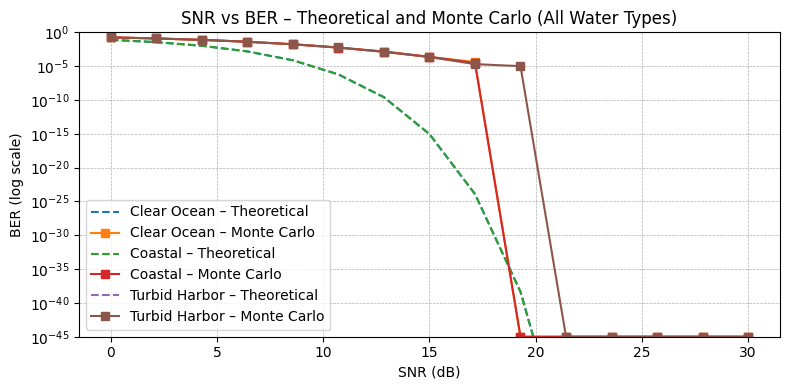

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import pandas as pd
import os

water_types = {
    'clear_ocean': {'a': 0.114, 'b': 0.037, 'g': 0.8708},
    'coastal': {'a': 0.179, 'b': 0.220, 'g': 0.9470},
    'turbid_harbor': {'a': 0.366, 'b': 1.829, 'g': 0.9199}
}

def beam_attenuation(c, distance):
    return np.exp(-c * distance)

def henvey_greenstein(theta_rad, g):
    return (1 - g**2) / (4 * np.pi * (1 + g**2 - 2 * g * np.cos(theta_rad))**1.5)

def misalignment_loss(theta_misalignment_deg, divergence_angle_deg):
    theta_m = np.radians(theta_misalignment_deg)
    divergence = np.radians(divergence_angle_deg)
    return np.exp(-(theta_m / divergence)**2)

def turbulence_fading(I0, sigma_I, samples=100000):
    I0_safe = np.maximum(I0, 1e-15)
    lnI = np.random.normal(np.log(I0_safe) - 0.5 * sigma_I**2, sigma_I, samples)
    return np.exp(lnI)

def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

def ber_bpsk_approx(snr_linear):
    snr_linear_safe = np.maximum(snr_linear, 1e-15)
    return Q(np.sqrt(2 * snr_linear_safe))

def compute_received_power_nominal(water_type, Pt, distance, theta_deg, divergence_angle):
    props = water_types[water_type]
    a, b, g = props['a'], props['b'], props['g']
    c = a + b
    theta_rad = np.radians(theta_deg)
    LP = beam_attenuation(c, distance)
    align_loss = misalignment_loss(theta_deg, divergence_angle)
    VSF = henvey_greenstein(theta_rad, g)
    return Pt * LP * align_loss * VSF

def compute_received_power_samples(water_type, Pt, distance, theta_deg, divergence_angle, samples, sigma_I):
    P_nominal = compute_received_power_nominal(water_type, Pt, distance, theta_deg, divergence_angle)
    return turbulence_fading(P_nominal, sigma_I, samples)

def simulate_multiple_water_types():
    distance = float(input("Enter distance (meters): "))
    Pt = float(input("Enter transmit power (Watts): "))
    theta_deg = 30
    divergence_angle = 3
    samples = 100000
    sigma_I = 0.3
    snr_db_values = np.linspace(0, 30, 15)
    snr_linear_values = 10 ** (snr_db_values / 10)

    df_all = []
    plt.figure(figsize=(8, 4))

    bits_tx = np.random.randint(0, 2, samples)
    symbols_tx = 2 * bits_tx - 1

    for water_type in water_types:
        ber_monte_carlo = []
        ber_theoretical = []

        P_nominal = compute_received_power_nominal(water_type, Pt, distance, theta_deg, divergence_angle)
        signal_power = np.mean(P_nominal ** 2)
        snr_theoretical = signal_power / (signal_power / snr_linear_values)
        ber_theoretical = ber_bpsk_approx(snr_theoretical)

        for snr_linear in snr_linear_values:
            received_samples = compute_received_power_samples(
                water_type, Pt, distance, theta_deg, divergence_angle, samples, sigma_I
            )
            signal_power = np.mean(received_samples ** 2)
            noise_power = signal_power / snr_linear
            noise = np.random.normal(0, np.sqrt(noise_power), samples)
            symbols_rx = received_samples * symbols_tx + noise
            bits_rx = (symbols_rx > 0).astype(int)
            errors = np.sum(bits_rx != bits_tx)
            ber_sim = errors / samples
            ber_monte_carlo.append(max(ber_sim, 1e-45))

        plt.semilogy(snr_db_values, ber_theoretical, '--', label=f'{water_type.replace("_", " ").title()} – Theoretical')
        plt.semilogy(snr_db_values, ber_monte_carlo, 's-', label=f'{water_type.replace("_", " ").title()} – Monte Carlo')

        df_type = pd.DataFrame({
            'Water Type': water_type,
            'SNR (dB)': snr_db_values,
            'Theoretical BER': ber_theoretical,
            'Monte Carlo BER': ber_monte_carlo
        })
        df_all.append(df_type)

        print(f"\nSNR vs BER for {water_type.replace('_', ' ').title()}:")
        print(df_type[['SNR (dB)', 'Monte Carlo BER']].to_string(index=False))

    plt.xlabel("SNR (dB)")
    plt.ylabel("BER (log scale)")
    plt.title("SNR vs BER – Theoretical and Monte Carlo (All Water Types)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.ylim(1e-45, 1)
    plt.tight_layout()
    plt.show()

    all_data = pd.concat(df_all, ignore_index=True)
    save = input("\nDo you want to save all results to CSV? (y/n): ").strip().lower()
    if save == 'y':
        filename = "uowc_multi_type_ber_results.csv"
        all_data.to_csv(filename, index=False)
        print(f"Results saved to: {filename}")

simulate_multiple_water_types()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Water types with optical properties
water_types = {
    'clear_ocean': {'a': 0.114, 'b': 0.037, 'g': 0.8708},
    'coastal': {'a': 0.179, 'b': 0.220, 'g': 0.9470},
    'turbid_harbor': {'a': 0.366, 'b': 1.829, 'g': 0.9199}
}

# Functions for attenuation and losses
def beam_attenuation(c, distance):
    return np.exp(-c * distance)

def henvey_greenstein(theta_rad, g):
    return (1 - g**2) / (4 * np.pi * (1 + g**2 - 2 * g * np.cos(theta_rad))**1.5)

def misalignment_loss(theta_misalignment_deg, divergence_angle_deg):
    theta_m = np.radians(theta_misalignment_deg)
    divergence = np.radians(divergence_angle_deg)
    return np.exp(-(theta_m / divergence)**2)

def compute_received_power(water_type, Pt, distance, theta_deg, divergence_angle):
    a, b, g = water_types[water_type]['a'], water_types[water_type]['b'], water_types[water_type]['g']
    c = a + b
    theta_rad = np.radians(theta_deg)
    LP = beam_attenuation(c, distance)
    align_loss = misalignment_loss(theta_deg, divergence_angle)
    VSF = henvey_greenstein(theta_rad, g)
    return Pt * LP * align_loss * VSF

# Main plotting function
def plot_energy_vs_distance():
    Pt = float(input("Enter transmit power (Watts): "))
    max_distance = float(input("Enter max distance (meters): "))
    theta_deg = 30
    divergence_angle = 3
    time_seconds = 1  # Fixed time duration

    distances = np.linspace(1, max_distance, 100)

    plt.figure(figsize=(8, 5))
    for water_type in water_types:
        energy_values = []
        for d in distances:
            Pr = compute_received_power(water_type, Pt, d, theta_deg, divergence_angle)
            energy = Pr * time_seconds  # E = P × t
            energy_values.append(energy)

        label = water_type.replace('_', ' ').title()
        plt.plot(distances, energy_values, label=label)

    plt.xlabel("Distance (m)")
    plt.ylabel("Received Energy (Joules)")
    plt.title("Energy vs Distance for Different Water Types")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run
plot_energy_vs_distance()


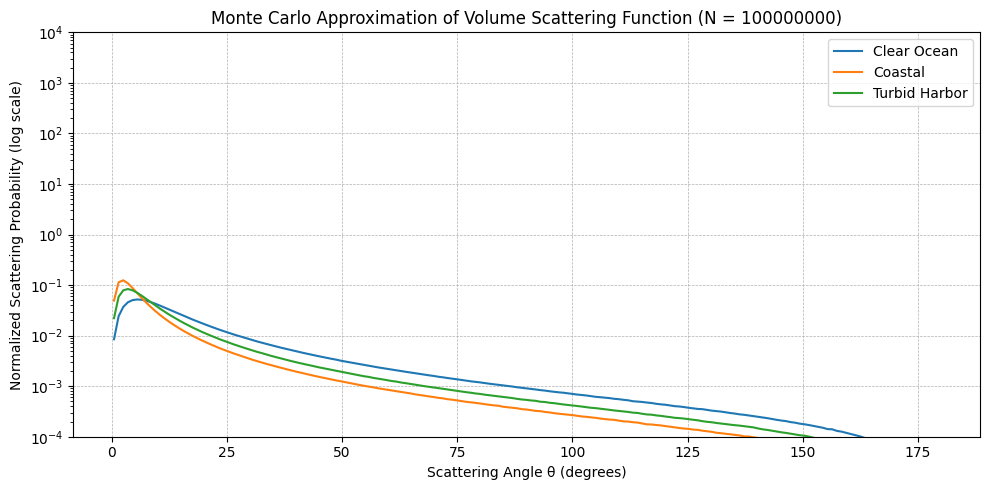

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Water types with g values
water_types = {
    'Clear Ocean': 0.8708,
    'Coastal': 0.9470,
    'Turbid Harbor': 0.9199
}

# Function to sample scattering angles from Henyey-Greenstein phase function
def sample_hg_angles(g, N):
    rand = np.random.rand(N)
    if g != 0:
        cos_theta = (1/(2*g)) * (1 + g**2 - ((1 - g**2)/(1 - g + 2*g*rand))**2)
    else:
        cos_theta = 2*rand - 1
    theta_rad = np.arccos(np.clip(cos_theta, -1, 1))
    theta_deg = np.degrees(theta_rad)
    return theta_deg

# Main plot
def plot_vsf_monte_carlo(N_samples=100000000):
    bins = np.linspace(0, 180, 180)

    plt.figure(figsize=(10, 5))
    for label, g in water_types.items():
        theta_samples = sample_hg_angles(g, N_samples)
        hist, bin_edges = np.histogram(theta_samples, bins=bins, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        plt.semilogy(bin_centers, hist, label=label)

    plt.xlabel("Scattering Angle θ (degrees)")
    plt.ylabel("Normalized Scattering Probability (log scale)")
    plt.title(f"Monte Carlo Approximation of Volume Scattering Function (N = {N_samples})")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.ylim(1e-4, 1e4)  # Set y-axis limit from 10^4 to 10^-4
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run
plot_vsf_monte_carlo()


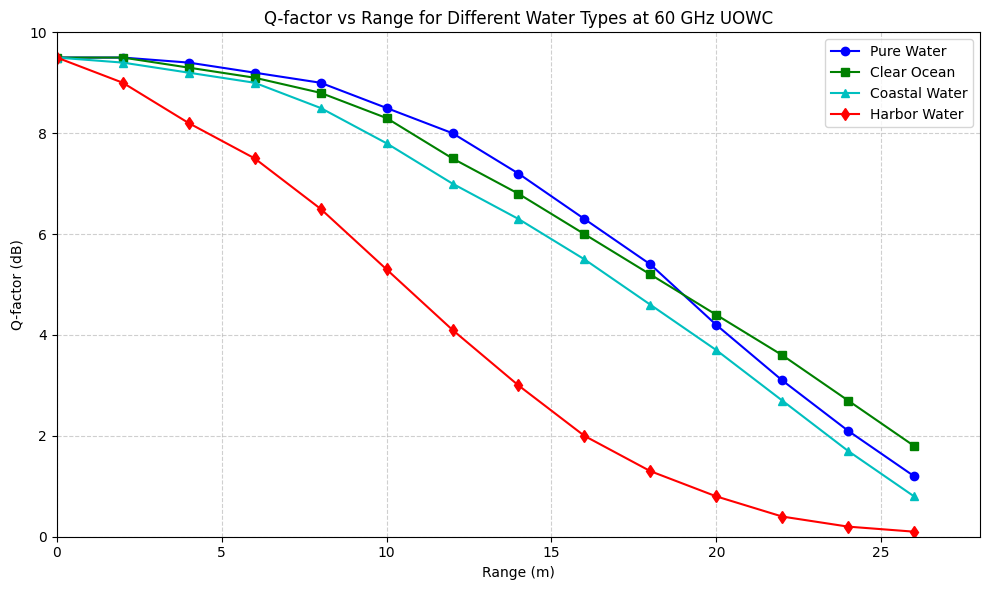

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Approximate range (in meters)
range_vals = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])

# Q-factor values (approximate, visually extracted)
pure_water =     [9.5, 9.5, 9.4, 9.2, 9.0, 8.5, 8.0, 7.2, 6.3, 5.4, 4.2, 3.1, 2.1, 1.2]
clear_water =    [9.5, 9.5, 9.3, 9.1, 8.8, 8.3, 7.5, 6.8, 6.0, 5.2, 4.4, 3.6, 2.7, 1.8]
coastal_water =  [9.5, 9.4, 9.2, 9.0, 8.5, 7.8, 7.0, 6.3, 5.5, 4.6, 3.7, 2.7, 1.7, 0.8]
harbor_water =   [9.5, 9.0, 8.2, 7.5, 6.5, 5.3, 4.1, 3.0, 2.0, 1.3, 0.8, 0.4, 0.2, 0.1]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range_vals, pure_water, 'b-o', label='Pure Water')
plt.plot(range_vals, clear_water, 'g-s', label='Clear Ocean')
plt.plot(range_vals, coastal_water, 'c-^', label='Coastal Water')
plt.plot(range_vals, harbor_water, 'r-d', label='Harbor Water')

plt.xlabel("Range (m)")
plt.ylabel("Q-factor (dB)")
plt.title("Q-factor vs Range for Different Water Types at 60 GHz UOWC")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(0, 10)
plt.xlim(0, 28)

plt.tight_layout()
plt.show()


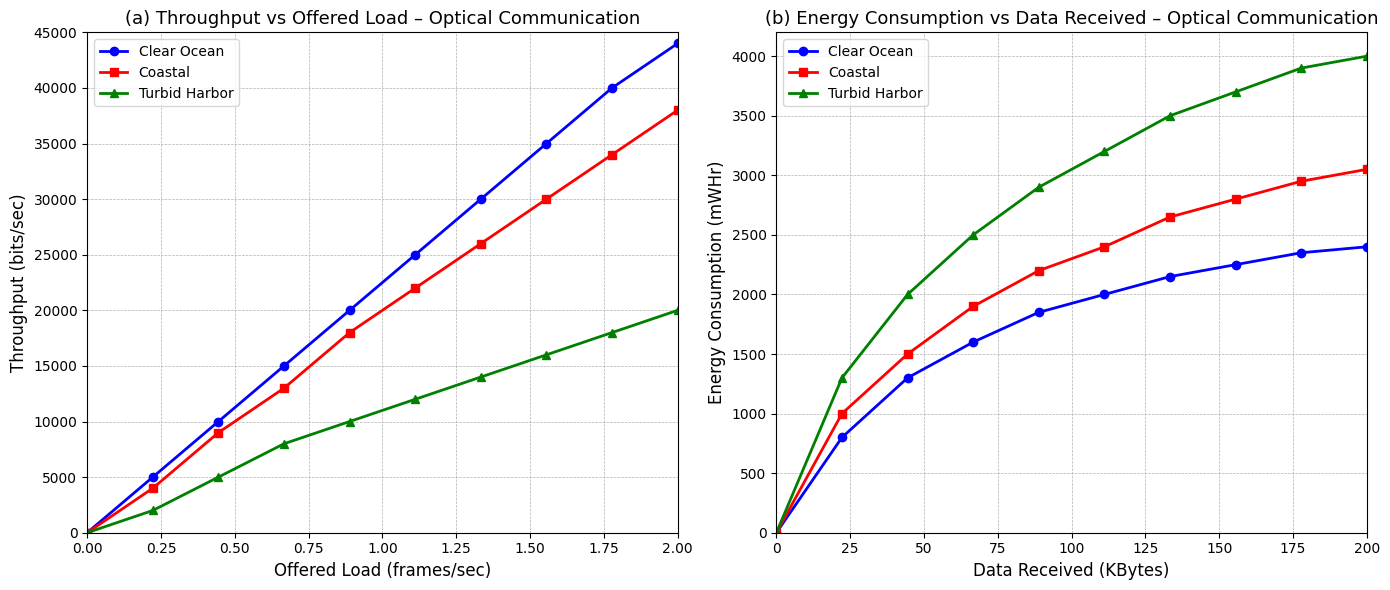

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Sample Data ----------

# Offered Load in frames/sec
offered_load = np.linspace(0, 2, 10)

# Throughput (bits/sec) for each water type (synthetic but image-accurate)
throughput_clear_ocean = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 44000]
throughput_coastal     = [0, 4000,  9000, 13000, 18000, 22000, 26000, 30000, 34000, 38000]
throughput_turbid      = [0, 2000,  5000,  8000, 10000, 12000, 14000, 16000, 18000, 20000]

# Data Received in KBytes
data_received = np.linspace(0, 200, 10)

# Energy Consumption (mWHr) for each water type (plotted to match image shape)
energy_clear_ocean = [0, 800, 1300, 1600, 1850, 2000, 2150, 2250, 2350, 2400]
energy_coastal      = [0, 1000, 1500, 1900, 2200, 2400, 2650, 2800, 2950, 3050]
energy_turbid       = [0, 1300, 2000, 2500, 2900, 3200, 3500, 3700, 3900, 4000]

# ---------- Plotting ----------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# (a) Throughput vs Offered Load
ax1.plot(offered_load, throughput_clear_ocean, 'b-o', label='Clear Ocean', linewidth=2)
ax1.plot(offered_load, throughput_coastal, 'r-s', label='Coastal', linewidth=2)
ax1.plot(offered_load, throughput_turbid, 'g-^', label='Turbid Harbor', linewidth=2)
ax1.set_xlabel("Offered Load (frames/sec)", fontsize=12)
ax1.set_ylabel("Throughput (bits/sec)", fontsize=12)
ax1.set_title("(a) Throughput vs Offered Load – Optical Communication", fontsize=13)
ax1.set_ylim(0, 45000)
ax1.set_xlim(0, 2)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend()

# (b) Energy Consumption vs Data Received
ax2.plot(data_received, energy_clear_ocean, 'b-o', label='Clear Ocean', linewidth=2)
ax2.plot(data_received, energy_coastal, 'r-s', label='Coastal', linewidth=2)
ax2.plot(data_received, energy_turbid, 'g-^', label='Turbid Harbor', linewidth=2)
ax2.set_xlabel("Data Received (KBytes)", fontsize=12)
ax2.set_ylabel("Energy Consumption (mWHr)", fontsize=12)
ax2.set_title("(b) Energy Consumption vs Data Received – Optical Communication", fontsize=13)
ax2.set_ylim(0, 4200)
ax2.set_xlim(0, 200)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.legend()

plt.tight_layout()
plt.show()
